In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from bs4 import BeautifulSoup
from selenium import webdriver
import QuantLib as ql
options = webdriver.ChromeOptions()
options.add_argument('headless')


In [2]:
def GET_DATE():
    driver = webdriver.Chrome('C:\it\python_workspace\chromedriver', options=options)
    driver.get("https://www.wsj.com/market-data/bonds")
    html = driver.page_source    
    soup = BeautifulSoup(html, 'html.parser')
    data = soup.find("span", class_="WSJBase--card__timestamp--3F2HxyAE")
    date = data.text
    date = date.split(' ')[3]
    date = datetime.datetime.strptime(date, "%m/%d/%y").date()
    return date

In [3]:
def GET_QUOTE(reference_date):
    driver = webdriver.Chrome('C:\it\python_workspace\chromedriver', options=options)
    tenors = ['01M', '03M', '06M', '01Y', '02Y', '03Y', '05Y', '07Y', '10Y', '30Y']
    
    # Create Empty Lists
    maturities = []
    days = []
    prices = []
    coupons = []
    
    # Get Market Information    
    for i, tenor in enumerate(tenors):
        driver.get("https://quotes.wsj.com/bond/BX/TMUBMUSD" + tenor + "?mod=md_bond_overview_quote")
        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')
        
        # Price
        if i <= 3:
            data_src = soup.find("span", id="quote_val")
            price = data_src.text
            price = float(price[:-1])
        else:
            data_src = soup.find("span", id="price_quote_val")
            price = data_src.text
            price = price.split()
            price1 = float(price[0])
            price = price[1].split('/')
            price2 = float(price[0])
            price3 = float(price[1])            
            price = price1 + (price2 / price3)  
            
        data_src2 = soup.find_all("span", class_="data_data")
        
        # Coupon
        coupon = data_src2[2].text
        if coupon != '':
            coupon = float(coupon[:-1])
        else:
            coupon = 0.0
        
        # Maturity Date
        maturity = data_src2[3].text
        maturity = datetime.datetime.strptime(maturity, '%m/%d/%y').date()
        
        # Send to Lists
        days.append((maturity - reference_date).days)
        prices.append(price)
        coupons.append(coupon)
        maturities.append(maturity)
    
    # Create DataFrame
    df = pd.DataFrame([maturities, days, prices, coupons]).transpose()
    headers = ['maturity', 'days', 'price', 'coupon']
    df.columns = headers
    df.set_index('maturity', inplace=True)
    
    return df

In [4]:
# Test
ref_date = GET_DATE()
quote = GET_QUOTE(ref_date)
print(quote)

             days    price coupon
maturity                         
2021-05-04     32    0.018      0
2021-07-01     90    0.018      0
2021-09-30    181     0.04      0
2022-03-24    356    0.063      0
2023-03-31    728  99.2812  0.125
2024-03-15   1078  99.1875   0.25
2026-03-31   1824  98.2812   0.75
2028-03-31   2555  98.2812   1.25
2031-02-15   3606  94.1875  1.125
2051-02-15  10911  89.2188  1.875


In [20]:
def TREASURY_CURVE(date, quote):
    
    # Divide Quotes
    tbill = quote[0:4]
    tbond = quote[4:]
    # 평가일 설정
    eval_date = ql.Date(date.day, date.month, date.year)
    ql.Settings.instance().evaluationDate = eval_date
    # 마켓 컨벤션 설정 #달력,금리설정일,이자계산방식,정산일자선정방식,명목금액,이자정산주기
    calendar = ql.UnitedStates()
    convention = ql.ModifiedFollowing
    day_counter = ql.ActualActual()
    end_of_month = True
    fixing_days = 1
    face_amount = 100
    coupon_frequency = ql.Period(ql.Semiannual)
    #Deposit Rate Helper
    #DepositRateHelper-무이표채에적용,
    #FixedRateBondHelper-이표채에적용
    bill_helpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(r/100.0)),
                                        ql.Period(m, ql.Days),
                                        fixing_days,
                                        calendar,
                                        convention,
                                        end_of_month,
                                        day_counter)
                   for r, m in zip(tbill['price'], tbill['days'])]
                #for 문으로 무이표채 금리와 잔존일수 데이터 입력
    # Construct Treasury Bond Helpers [ Fixed Bond Rate Helper ]
    bond_helpers = []
    for p, c, m in zip(tbond['price'], tbond['coupon'], tbond['days']):
        termination_date = eval_date + ql.Period(m, ql.Days)
        schedule = ql.Schedule(eval_date,
                              termination_date,
                              coupon_frequency,
                              calendar,
                              convention,
                              convention,
                              ql.DateGeneration.Backward,
                              end_of_month)
        bond_helper = ql.FixedRateBondHelper(ql.QuoteHandle(ql.SimpleQuote(p)),
                                            fixing_days,
                                             face_amount,
                                             schedule,
                                             [c/100.0],
                                             day_counter,
                                             convention)
        bond_helpers.append(bond_helper)
        # FixedRateBondHelper - 이표채 이자지급스케쥴 생성
    # 헬퍼 결합(무이표채 + 이표채)
    rate_helper = bill_helpers + bond_helpers
    # 헬퍼를 커브 모듈에 태우기
    yc_linearzero = ql.PiecewiseLinearZero(eval_date, rate_helper, day_counter)
    return yc_linearzero

In [9]:
def DISCOUNT_FACTOR(date, curve):
    date = ql.Date(date.day, date.month, date.year)
    return curve.discount(date)
# 특정일을 알려주면 할인계수 얼마인지 * 날짜를 퀀트립의 날짜 형식에 맞춰주기

In [10]:
def ZERO_RATE(date, curve):
    date = ql.Date(date.day, date.month, date.year)
    day_counter = ql.ActualActual()
    compounding = ql.Compounded
    freq = ql.Continuous
    zero_rate = curve.zeroRate(date, day_counter, compounding, freq).rate()
    return zero_rate

# 특정 날짜의 제로금리가 얼마인지

            discount factor  zero rate
maturity                              
2021-05-04         0.999984   0.000180
2021-07-01         0.999956   0.000180
2021-09-30         0.999870   0.000262
2022-03-24         0.999531   0.000481
2023-03-31         0.990421   0.004832
2024-03-15         0.984560   0.005277
2026-03-31         0.946646   0.011008
2028-03-31         0.899556   0.015187
2031-02-15         0.838299   0.017943
2051-02-15         0.475483   0.025041


Text(0, 0.5, 'Discount Factor')

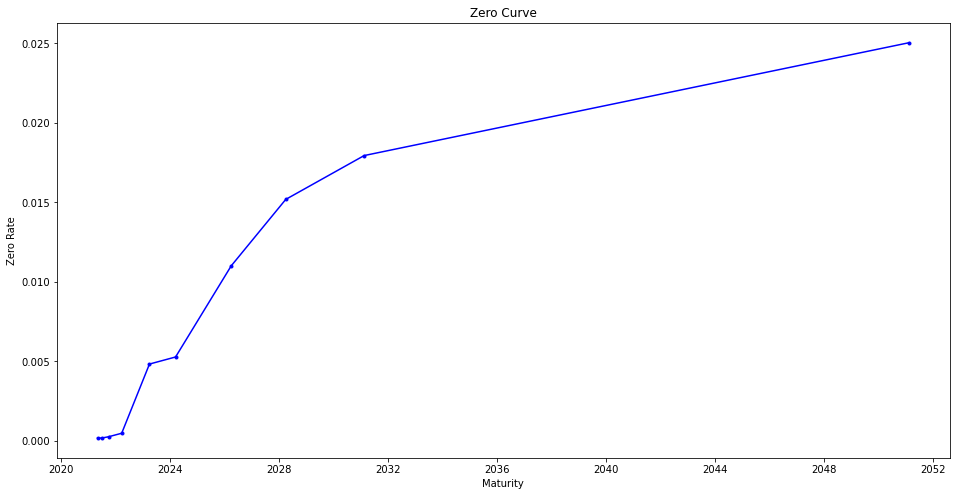

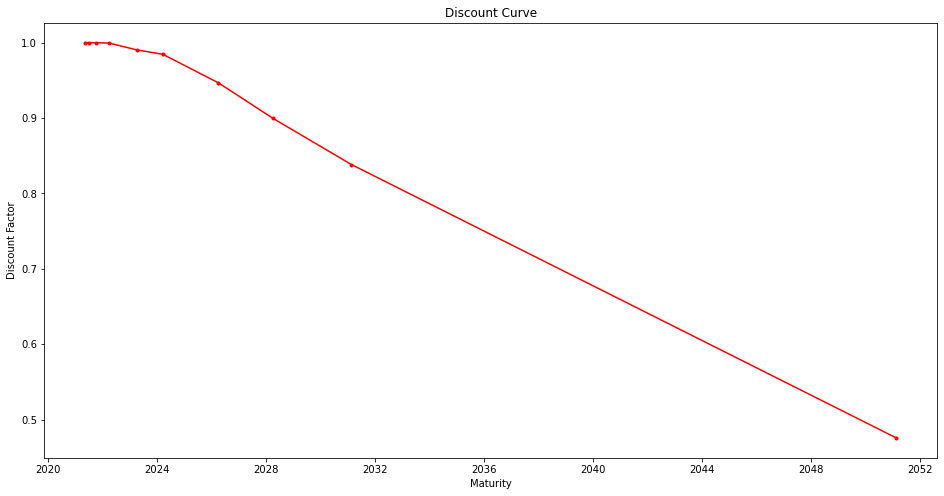

In [25]:
ref_date = GET_DATE()
quote = GET_QUOTE(ref_date)
curve = TREASURY_CURVE(ref_date, quote)

quote['discount factor'] = np.nan
quote['zero rate'] = np.nan

for date in quote.index:
    quote.loc[date, 'discount factor'] = DISCOUNT_FACTOR(date, curve)
    quote.loc[date, 'zero rate'] = ZERO_RATE(date, curve)
    
print(quote[['discount factor', 'zero rate']])

plt.figure(figsize=(16,8))
plt.plot(quote['zero rate'], 'b.-')
plt.title('Zero Curve', loc='center')
plt.xlabel('Maturity')
plt.ylabel('Zero Rate')

plt.figure(figsize=(16,8))
plt.plot(quote['discount factor'], 'r.-')
plt.title('Discount Curve', loc='center')
plt.xlabel('Maturity')
plt.ylabel('Discount Factor')
